In [1]:
import pandas as pd
import io
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt

In [2]:
wd = os.getcwd() + '\\'

# All merged data is available near the bottom under "dartmouthdata" excel file

In [3]:
# Creates a data dictionary for state to abbreviation

us_state_to_abbrev = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA", "Colorado": "CO", "Connecticut": "CT",
    "Delaware": "DE","Florida": "FL","Georgia": "GA","Hawaii": "HI","Idaho": "ID","Illinois": "IL","Indiana": "IN","Iowa": "IA",
    "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN",
    "Mississippi": "MS",  "Missouri": "MO",  "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ",
    "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR",
    "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT",
    "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY",
    "District of Columbia": "DC", "American Samoa": "AS", "Guam": "GU", "Northern Mariana Islands": "MP", "Puerto Rico": "PR",  "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
    
# invert the dictionary
abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

In [4]:
renamer = {'state_y':'state', 'county_y':'county'}

# Hospital to HSA crosswalk (2007 - 2015)

### Years - 07, 08, 09 are copies of 10 b/c they do not exist separately. There is another file that gives reason to believe this is not violative

In [5]:
yearlist = ['07', '08', '09', '10', '11','12','13','14','15', '16', '17']
collist = ['PROVIDER', 'HSA', 'HSANAME', 'FCNTYNAME', 'TEACHSTATUS']
nameslist = ['provider.id', 'hsa.num', 'hsa.name', 'fcntyname', 'teachstatus', 'year', 'state', 'county']

crosswalk = pd.DataFrame()

for i in yearlist:
    data = pd.read_excel(wd + 'Crosswalks\\' + 'hosp{0}.xlsx'.format(i), usecols = collist)
    
    year = '20{}'.format(i)
    year = int(year)
    data['year'] = year
    
    if '-' in data['FCNTYNAME'][0]:
        data[['state', 'county', 'dropme']] = data['FCNTYNAME'].str.split('-', expand = True)
    else:
        data[['county', 'state']] = data['FCNTYNAME'].str.split(',', expand = True)
    
    crosswalk = pd.concat([crosswalk, data])
    
    
crosswalk.reset_index(inplace = True)

crosswalk.drop(['dropme', 'index'], axis  = 1, inplace = True)
crosswalk['county'] = crosswalk['county'].str.replace(' County', '')
crosswalk['county'] = crosswalk['county'].str.strip()
crosswalk['county'] = crosswalk['county'].str.title()


crosswalk.columns = nameslist
crosswalk['provider.id'] = pd.to_numeric(crosswalk['provider.id'], errors = 'coerce')

### Recode the hospital teaching status to a numeric number
for i in crosswalk.index:
    if str(crosswalk.loc[i, 'teachstatus']) == 'nan':
        crosswalk.loc[i, 'teachstatus'] = 0
    elif str(crosswalk.loc[i, 'teachstatus']) == 'Major Teaching':
        crosswalk.loc[i, 'teachstatus'] = 3
    elif str(crosswalk.loc[i, 'teachstatus']) == 'Minor Teaching':
        crosswalk.loc[i, 'teachstatus'] = 2
    else:
        crosswalk.loc[i, 'teachstatus'] = 1
        
crosswalk['teachstatus'] = pd.to_numeric(crosswalk['teachstatus'], errors = 'coerce')

In [6]:
crosswalk['state'] = crosswalk['state'].str.strip()
crosswalk = crosswalk.loc[crosswalk['state'].str.len() == 2]


In [7]:
newstate = [abbrev_to_us_state[state] for state in crosswalk['state']]
crosswalk.loc[:,'state'] = newstate
crosswalk['state'] = crosswalk['state'].str.title()
crosswalk['state'] = crosswalk['state'].str.strip()

### This subsection creates the crosswalk for County to HSA

In [8]:
hsa_crosswalk = crosswalk.drop(['provider.id', 'hsa.name', 'fcntyname', 'teachstatus', 'year'], axis = 1)
grouped = hsa_crosswalk.groupby(['hsa.num', 'county'])['state'].agg(pd.Series.mode)
hsa_crosswalk = grouped.reset_index()

# Mortality Data (2005-2017) - HSA

In [9]:
### Grab  and create a dataframe from all the data

yearlist = ['05', '06', '07', '08', '09', '10', '11','12','13','14','15','16','17']
nameslist = ['hsa.num', 'hsa.name', 'med.enrollee', 'tot.mort.%', 'non.hmo.mort.%', 'year']

ogcols = ['HSA #', 'HSA Name', 'Medicare Enrollees', 
                             'Total Mortality: ASR-adjusted Percent of Deaths among Medicare Enrollees',
                             'Non-HMO Mortality: ASR-adjusted Percent of Deaths among Medicare Enrollees without HMO Coverage',
                             'Year']
mortality = pd.DataFrame()

for i in yearlist:
    data = pd.read_csv(wd + 'Mortality\\' + '20{}_mortality_hsa.csv'.format(i))
    if data.shape[1] == 5:
        year = '20{}'.format(i)
        year = int(year)
        data['year'] = year
        data.columns = nameslist
    else: 
        data = data.reindex(columns=ogcols)
        data.columns = nameslist
        
    mortality= pd.concat([mortality, data])

### Reset the index and fix the county/state labelling

mortality.reset_index(inplace = True)
mortality[['state', 'county', 'dropme']] = mortality['hsa.name'].str.split('-', expand = True)
mortality.drop('dropme', axis =1, inplace = True)
mortality['county'] = mortality['county'].str.title()


### Force the data to be numeric where appropriate

mortality['med.enrollee'] = mortality['med.enrollee'].str.replace(',','')

for name in ['tot.mort.%', 'non.hmo.mort.%', 'med.enrollee']:
   
    mortality[name] = pd.to_numeric(mortality[name], errors = 'coerce')
    
    # I"m not sure why, but this version of removing -88888 values is the only one that doesn't f the data
    mortality = mortality.loc[~(mortality[name] == -88888)]


In [10]:
mortality1 = pd.merge(mortality, hsa_crosswalk, on = ['hsa.num'], how = 'left', indicator = True)

In [11]:
mortality1 = mortality1.groupby(['state_y', 'county_y', 'year']).mean(numeric_only = True).reset_index()

In [12]:
mortality1['year'] = pd.to_datetime(mortality1['year'].astype(str))
mortality1 = mortality1.rename(columns = renamer)
mortality1.set_index(['state', 'county', 'year'], inplace = True)

# Medical Discharge Data (2005 - 2015) - HSA

In [13]:
### Grab  and create a dataframe from all the data

yearlist = ['05', '06', '07', '08', '09', '10', '11','12','13','14','15']


nameslist = ['hsa.num', 'hsa.label', 'med.enrollee', 'med.dis.per.1000', 'med.dis.noacs.per.1000', 'dis.amb.care.per.1000', 
             'dis.conv.per.1000', 'dis.copd.per.1000', 'dis.bact.pneu.per.1000', 'dis.asth.per.1000', 'dis.chf.per.1000', 
             'dis.hpt.per.1000', 'dis.angi.per.1000', 'dis.cell.per.1000', 'dis.diab.per.1000', 'dis.gast.per.1000', 'dis.kid.per.1000', 'dis.dehyd.per.1000', 'year']

med_discharge = pd.DataFrame()

for i in yearlist:
    data = pd.read_csv(wd + 'MedicalDischarges\\' + '20{}_med_discharges_hsa.csv'.format(i))
    if data.shape[1] == 18:
        year = '20{}'.format(i)
        year = int(year)
        data['year'] = year
        data.columns = nameslist
        
    med_discharge = pd.concat([med_discharge, data])

    
### Reset the index and fix the county/state labelling

med_discharge.reset_index(inplace = True)
med_discharge[['state', 'county', 'dropme']] = med_discharge['hsa.label'].str.split('-', expand = True)
med_discharge.drop('dropme', axis =1, inplace = True)
med_discharge['county'] = med_discharge['county'].str.title()

### This fixes parentheses to allow for negative values and then converts to a float/int

med_discharge['med.enrollee'] = med_discharge['med.enrollee'].str.replace(',','')

for name in med_discharge.columns[2:19]:
    med_discharge[name] = med_discharge[name].str.replace('\(' , '-', regex = True)
    med_discharge[name] = med_discharge[name].str.replace('\)', '', regex = True)
    med_discharge[name] = pd.to_numeric(med_discharge[name], errors = 'coerce')

In [14]:
med_discharge1 = pd.merge(med_discharge, hsa_crosswalk, on = ['hsa.num'], how = 'left', indicator = True)

In [15]:
med_discharge1 = med_discharge1.groupby(['state_y', 'county_y', 'year']).mean(numeric_only = True).reset_index()

In [16]:
med_discharge1['year'] = pd.to_datetime(med_discharge1['year'].astype(str))
med_discharge1 = med_discharge1.rename(columns = renamer)
med_discharge1.set_index(['state', 'county', 'year'], inplace = True)

In [17]:
med_discharge1

index  hsa.num  hsa.label  med.enrollee  \
state   county  year                                                   
Alabama Autauga 2005-01-01    53.0   1070.0        NaN        4038.0   
                2006-01-01    53.0   1070.0        NaN        3933.0   
                2007-01-01    53.0   1070.0        NaN        3896.0   
                2008-01-01    53.0   1070.0        NaN        3570.0   
                2009-01-01    53.0   1070.0        NaN        3534.0   
...                            ...      ...        ...           ...   
Wyoming Weston  2011-01-01  3425.0  53016.0        NaN        1063.0   
                2012-01-01  3425.0  53016.0        NaN        1093.0   
                2013-01-01  3425.0  53016.0        NaN        1143.0   
                2014-01-01  3425.0  53016.0        NaN        1192.0   
                2015-01-01  3425.0  53016.0        NaN         903.0   

                            med.dis.per.1000  med.dis.noacs.per.1000  \
state   county  year                                                   
Alabama Autauga 2005-01-01             239.1                   141.6   
                2006-01-01             246.6                   164.7   
                2007-01-01             242.9                   172.5   
                2008-01-01             257.3                   176.6   
                2009-01-01             250.5                   162.7   
...                                      ...                     ...   
Wyoming Weston  2011-01-01             181.6                   120.4   
                2012-01-01             150.2                   108.1   
                2013-01-01             117.3                    78.3   
                2014-01-01             126.0                    95.7   
                2015-01-01             132.1                   102.3   

                            dis.amb.care.per.1000  dis.conv.per.1000  \
state   county  year                                                   
Alabama Autauga 2005-01-01                  102.8                NaN   
                2006-01-01                   84.9                NaN   
                2007-01-01                   72.8                NaN   
                2008-01-01                   80.7                NaN   
                2009-01-01                   87.8                NaN   
...                                           ...                ...   
Wyoming Weston  2011-01-01                   62.0                NaN   
                2012-01-01                   42.2                NaN   
                2013-01-01                   40.7                NaN   
                2014-01-01                   31.1                NaN   
                2015-01-01                   29.8                NaN   

                            dis.copd.per.1000  dis.bact.pneu.per.1000  \
state   county  year                                                    
Alabama Autauga 2005-01-01              14.89                   26.77   
                2006-01-01              14.23                   24.10   
                2007-01-01              10.07                   17.43   
                2008-01-01              12.93                   21.92   
                2009-01-01              13.23                   22.55   
...                                       ...                     ...   
Wyoming Weston  2011-01-01             -15.59                  -17.13   
                2012-01-01             -10.73                  -13.19   
                2013-01-01                NaN                  -14.50   
                2014-01-01                NaN                  -11.34   
                2015-01-01                NaN                     NaN   

                            dis.asth.per.1000  dis.chf.per.1000  \
state   county  year                                              
Alabama Autauga 2005-01-01              -3.06             34.50   
                2006-01-01                NaN             19.31   


# Surgical Discharge Rates (2005 - 2015) - HSA

In [18]:
### Grab  and create a dataframe from all the data

yearlist = ['05', '06', '07', '08', '09', '10', '11','12','13','14','15']


nameslist = ['hsa.num', 'hsa.label', 'med.enrollee', 'surg.dis.per.1000', 'aaa.per.1000', 'back.surg.per.1000', 
             'coron.angio.per.1000', 'coron.art.per.1000', 'perc.coron.per.1000', 'carot.endar.per.1000', 
             'cholec.per.1000', 'hip.frac.per.1000', 'hip.rep.per.1000', 'knee.rep.per.1000', 'mastec.per.1000', 
             'colon.resec.per.1000', 'low.ext.revas.per.1000', 'pros.benign.per.1000', 'aor/mit.rep.per.1000', 'rad.pros.per.1000', 'year']
             

surg_discharge = pd.DataFrame()

for i in yearlist:
    data = pd.read_csv(wd + 'SurgicalDischarges\\' + '20{}_surg_discharges_hsa.csv'.format(i), index_col = False)
    if data.shape[1] == 20:
        year = '20{}'.format(i)
        year = int(year)
        data['year'] = year
        data.columns = nameslist
 
        
    surg_discharge = pd.concat([surg_discharge, data])

### Reset the index and fix the county/state labelling


surg_discharge.reset_index(inplace = True)
surg_discharge[['state', 'county', 'dropme']] = surg_discharge['hsa.label'].str.split('-', expand = True)
surg_discharge.drop(columns = ['index', 'dropme'], axis =1, inplace = True)
surg_discharge['county'] = surg_discharge['county'].str.title()

### This fixes parentheses to allow for negative values and then converts to a float/int

surg_discharge['med.enrollee'] = surg_discharge['med.enrollee'].str.replace(',','')

for name in surg_discharge.columns[2:20]:
    surg_discharge[name] = surg_discharge[name].str.replace('\(' , '-', regex = True)
    surg_discharge[name] = surg_discharge[name].str.replace('\)', '', regex = True)
    surg_discharge[name] = pd.to_numeric(surg_discharge[name], errors = 'coerce')

In [19]:
surg_discharge1 = pd.merge(surg_discharge, hsa_crosswalk, on = ['hsa.num'], how = 'left', indicator = True)

In [20]:
surg_discharge1 = surg_discharge1.groupby(['state_y', 'county_y', 'year']).mean(numeric_only = True).reset_index()

In [21]:
surg_discharge1['year'] = pd.to_datetime(surg_discharge1['year'].astype(str))
surg_discharge1 = surg_discharge1.rename(columns = renamer)
surg_discharge1.set_index(['state', 'county', 'year'], inplace = True)

# Chronically Ill last 2 Years (2008- 2015) - HOSPITAL

### This will require a hospital to HSA crosswalk

In [22]:
nameslist = ['hrr', 'hrr.name', 'provider.id', 'hospital.name', 'city', 'state', 'system', 'num.dead.chronic.2yr',
             'pct.enrol.inpat.hosp.2yr', 'hci.2yr', 'total.med.spend.2yr', 'med.spend.inpat.2yr', 'med.spend.out.2yr', 'med.spend.snf.2yr', 'med.spend.home.2yr',
             'med.spend.hosp.2yr', 'med.spend.amb.2yr', 'med.spend.dme.2yr', 'med.spend.other.2yr', 'total.medb.spend.2yr', 'medb.spend.eval.2yr', 'medb.spend.proc.2yr',
             'medb.spend.imag.2yr', 'medb.spend.test.2yr', 'medb.spend.other.2yr', 'hosp.reimb.2yr', 'hosp.days.2yr', 'reimb.pt.day.2yr', 'ratio.hosp.reimb.2yr', 'ratio.hosp.days.2yr',
             'ratio.reimb.pt.day.2yr', 'phys.pay.per.2yr', 'phys.visit.per.2yr', 'pay.per.phys.visit.2yr', 'ratio.phys.pay.2yr', 'ratio.phys.visit.2yr', 'ratio.pay.per.phys.visit.2yr', 'hosp.beds.1000', 
             'int.care.beds.1000', 'int.care.high.1000', 'int.care.med.1000', 'med/surg.beds.1000', 'snf.beds.1000', 'fte.phys.1000', 'fte.medspec.1000', 'fte.primcare.1000', 'ratio.fte.ms/pc.1000', 
             'req.rns.1000', 'hosp.days.per.dead', 'int.days.per.dead', 'int.care.high.dead', 'int.care.med.dead', 'med/surg.day.dead', 'snf.day.dead', 'phys.visit.dead', 'phys.visit.medspec.dead', 
             'phys.visit.primcare.dead', 'ratio.phys.visist.ms/pc.dead', 'home.health.visit.dead', 'pct.death.hosp', 'pct.death.with.icu', 'pct.hospice', 'hospice.day.per.dead', 'pct.pt.10+phys',
             'num.diff.phys.dead', 'avg.copay.dead', 'avg.copay.phys.dead', 'avg.copay.dme.dead', 'year']

In [23]:
### Grab  and create a dataframe from all the data

yearlist = ['08', '09', '10', '11','12','13','14','15']
             
chronic_care = pd.DataFrame()

for i in yearlist:
    data = pd.read_csv(wd + 'ChronicCare\\' + 'DAP_hospital_data_20{0}.csv'.format(i), skiprows = 1, skip_blank_lines = True)
    data = data.drop(columns = data.columns[data.columns.str.contains('Unnamed')])
    if data.shape[1] == 68:
        year = '20{}'.format(i)
        year = int(year)
        data['year'] = year
        data.columns = nameslist
 
        
    chronic_care = pd.concat([chronic_care, data])

### Reset the index and fix the city labelling

chronic_care.reset_index(inplace = True)
chronic_care['city'] = chronic_care['city'].str.title()

### This fixes parentheses to allow for negative values and then converts to a float/int

for name in chronic_care.columns[7:69]:
    if type(chronic_care[name][1]) == str:
        chronic_care[name] = chronic_care[name].str.replace('\(' , '-', regex = True)
        chronic_care[name] = chronic_care[name].str.replace('\)', '', regex = True)
        chronic_care[name] = pd.to_numeric(chronic_care[name], errors = 'coerce')

In [24]:
chronic_care1 = pd.merge(chronic_care, crosswalk, on = ['provider.id', 'year'], how = 'left')

In [25]:
chronic_care1 = chronic_care1.loc[~chronic_care1['hsa.num'].isna()]

In [26]:
chronic_care1.fillna(0, inplace = True)

In [27]:
### This process takes the values in this data and groups it by hsa and year and averages out duplicates
#chronic_care3 = chronic_care1.drop(['hospital.name', 'city', 'state_x', 'hsa.name', 'fcntyname'], axis = 1)

chronic_care3 = chronic_care1.groupby(['state_y','county', 'year'], as_index = False).mean(numeric_only = True)

In [28]:
chronic_care3['year'] = pd.to_datetime(chronic_care3['year'].astype(str))
chronic_care3 = chronic_care3.rename(columns = {'state_y':'state'})
chronic_care3.set_index(['state', 'county', 'year'], inplace = True)

In [29]:
### Like above, this is averaging up to the hsa level given that we were using hospital level data
chronic_care2 = chronic_care1.groupby(['hsa.num', 'year'], as_index = False).mean(numeric_only = True)

Chronic care does not have all the HSA's, instead it only has 2004 out of the expected 3437

# End of Life Care Last 6-Months (2006 - 2016) - HSA

In [30]:
### Grab  and create a dataframe from all the data

yearlist = ['06', '07', '08', '09', '10', '11','12','13','14','15', '16']


nameslist = ['hsa.num', 'hsa.label', 'medicare.deaths', 'pct.med.hosp.6mo', 'days.inpat.6mo', 'spend.inpat.6mo',
            'pct.deaths.hosp.6mo', 'inpat.days.during.death.6mo', 'inpat.spend.during.death.6mo', 'pct.icu/ccu.during.death.6mo',
            'icu/ccu.days.death.6mo', 'icu/ccu.during.death.6mo', 'pct.icu/ccu.6mo', 'ice/ccu.days.6mo', 'pct.7+day.icu.6mo', 'icu/ccu.spend.6mo', 'year']

endoflife = pd.DataFrame()

for i in yearlist:
    data = pd.read_csv(wd + 'EndoflifeCare\\' + '20{}_eol_medpar_hsa.csv'.format(i))
    if data.shape[1] == 16:
        year = '20{}'.format(i)
        year = int(year)
        data['year'] = year
        data.columns = nameslist
    else:
        data.drop('Year', axis = 1, inplace = True)
        year = '20{}'.format(i)
        year = int(year)
        data['year'] = year
        data.columns = nameslist
        
    endoflife = pd.concat([endoflife, data])

### Reset the index and fix the county/state labelling

endoflife.reset_index(inplace = True)
endoflife[['state', 'county', 'dropme']] = endoflife['hsa.label'].str.split('-', expand = True)
endoflife.drop('dropme', axis =1, inplace = True)
endoflife.drop('index', axis =1, inplace = True)
endoflife['county'] = endoflife['county'].str.title()

### This fixes parentheses to allow for negative values and then converts to a float/int

endoflife['medicare.deaths'] = endoflife['medicare.deaths'].str.replace(',','')

for name in endoflife.columns[2:17]:
    if type(endoflife[name][1]) == str:
        endoflife[name] = endoflife[name].str.replace('\(' , '-', regex = True)
        endoflife[name] = endoflife[name].str.replace('\)', '', regex = True)
        endoflife[name] = pd.to_numeric(endoflife[name], errors = 'coerce')

In [31]:
endoflife1 = pd.merge(endoflife, hsa_crosswalk, on = ['hsa.num'], how = 'left', indicator = True)

In [32]:
endoflife1 = endoflife1.groupby(['state_y', 'county_y', 'year']).mean(numeric_only = True).reset_index()

In [33]:
endoflife1['year'] = pd.to_datetime(endoflife1['year'].astype(str))
endoflife1 = endoflife1.rename(columns = renamer)
endoflife1.set_index(['state', 'county', 'year'], inplace = True)

# Post Discharge Events (2008 - 2016) - HOSPITAL

In [34]:
### Prepare necessary lists
commoncols = ['Hospital ID', 'Hospital name', 'City', 'State']
yearlist = ['08', '09', '10', '11','12','13','14','15']
sheetnames = ['Medical cohort', 'Surgical cohort', 'CHF cohort', 'AMI cohort', 'Pneumonia cohort']

### Iterate through years (i) and through sheets (j) while maintaing column uniqueness
postdischarge = pd.DataFrame()

for i in yearlist:
    data1 = pd.read_excel(wd + 'PostDischarge\\' + 'post_discharge_events_hospital_20{0}.xlsx'.format(i), sheet_name = 'Medical cohort')
    data2 = pd.read_excel(wd + 'PostDischarge\\' + 'post_discharge_events_hospital_20{0}.xlsx'.format(i), sheet_name = 'Surgical cohort')
    data3 = pd.read_excel(wd + 'PostDischarge\\' + 'post_discharge_events_hospital_20{0}.xlsx'.format(i), sheet_name = 'CHF cohort')
    data4 = pd.read_excel(wd + 'PostDischarge\\' + 'post_discharge_events_hospital_20{0}.xlsx'.format(i), sheet_name = 'AMI cohort')
    data5 = pd.read_excel(wd + 'PostDischarge\\' + 'post_discharge_events_hospital_20{0}.xlsx'.format(i), sheet_name = 'Pneumonia cohort')

    data = [data1, data2, data3, data4, data5] 
    
    ### This portion is mostly to edit the columns while keeping them unique
    for j in range(len(sheetnames)):
        data[j].drop(columns = data[j].columns[data[j].columns.str.contains('Unnamed')], axis = 1, inplace = True)
        data[j].drop(0, axis = 0, inplace = True)
        data[j].columns = data[j].columns.str.replace('\(20{0}\)'.format(i), '', regex = True)
        data[j].columns = data[j].columns.str.strip()
    
        
        newcols = [varname + sheetnames[j] for varname in data[j].columns[4:]]
        firstcols = data[j].columns[:4].tolist()
        totalcols = firstcols + newcols

        data[j].columns = totalcols
        
    ### Merge all five sheets into one new dataframe
    
    merged = pd.merge(pd.merge(pd.merge(pd.merge(data1, data2, on = commoncols, how = 'outer'), data3, on = commoncols, how = 'outer'), data4, on = commoncols, how = 'outer'), data5, on = commoncols, how = 'outer')
    
    year = '20{}'.format(i)
    year = int(year)
    merged['year'] = year
        
    postdischarge = pd.concat([postdischarge, merged])

### Rename the new dataframe

newnames = ['provider.id', 'hospital.name', 'city', 'state', 'num.med.coh', 'pct.readmin.30.med', 'pct.primary.14.med', 
            'pct.ambu.14.med', 'pct.er.30.med', 'num.surg.coh', 'pct.readmin.30.surg', 'pct.primary.14.surg', 'pct.er.30.surg', 
            'num.chf.coh', 'pct.readmin.30.chf', 'pct.primary.14.chf', 'pct.ambu.14.chf', 'pct.er.30.chf', 'num.ami.coh',
            'pct.readmin.30.ami', 'pct.primary.14.ami', 'pct.ambu.14.ami', 'pct.er.30.ami', 'num.pneum.coh',
            'pct.readmin.30.pneum', 'pct.primary.14.pneum', 'pct.ambu.14.pneum', 'pct.er.30.pneum', 'year']


postdischarge.columns = newnames
postdischarge.reset_index(inplace = True)


for name in postdischarge.columns[5:]:
    if type(postdischarge[name][1]) == str:
        postdischarge[name] = postdischarge[name].str.replace('\(' , '-', regex = True)
        postdischarge[name] = postdischarge[name].str.replace('\)', '', regex = True)
    
    postdischarge[name] = pd.to_numeric(postdischarge[name], errors = 'coerce')
    
postdischarge.drop('index', axis =1, inplace = True)

In [35]:
# Merge the cross walk data to the postdischarge dataset

postdischarge1 = pd.merge(postdischarge, crosswalk, on = ['provider.id', 'year'], how = 'left')

In [36]:
### This process takes the values in this data and groups it by hsa and year and averages out duplicates
postdischarge3 = postdischarge1.drop(['hospital.name', 'city', 'state_x', 'hsa.name', 'fcntyname'], axis = 1)

postdischarge3 = postdischarge3.groupby(['state_y','county', 'year'], as_index = False).mean()

In [37]:
postdischarge3['year'] = pd.to_datetime(postdischarge3['year'].astype(str))
postdischarge3 = postdischarge3.rename(columns = {'state_y':'state'})
postdischarge3.set_index(['state', 'county', 'year'], inplace = True)

# Primary Care Access and Quality Measures (2008 - 2014) - HSA

In [38]:
yearlist = ['08', '09', '10', '11','12','13','14']


nameslist = ['hsa.num', 'hsa.name', 'overall.medicare', 'black.medicare',
            'white.medicare', 'one.prim.care.overall', 'one.prim.care.black', 'one.prim.care.white',
            'diab.65-75.overall', 'diab.65-75.black', 'diab.65-75.white', 
            'pct.diab.hemo.65-75.overall', 'pct.diab.hemo.65-75.black', 'pct.diab.hemo.65-75.white',
            'pct.diab.eye.65-75.overall', 'pct.diab.eye.65-75.black', 'pct.diab.eye.65-75.white', 
            'pct.diab.ldl.65-75.overall', 'pct.diab.ldl.65-75.black', 'pct.diab.ldl.65-75.white',
            'num.fem.67-69.overall', 'num.fem.67-69.black', 'num.fem.67-69.white', 
            'pct.fem.mamo.overall', 'pct.fem.mamo.black', 'pct.fem.mamo.white', 
            'num.part.a.overall', 'num.part.a.black', 'num.part.a.white',
            'leg.amp.per.1000.overall', 'leg.amp.per.1000.black', 'leg.amp.per.1000.white', 
            'dis.ambu.care.sens.per.1000.overall', 'dis.ambu.care.sens.per.1000.black', 'dis.ambu.care.sense.per.1000.white', 'year']

primarycare = pd.DataFrame()

for i in yearlist:
    data = pd.read_excel(wd + 'PrimaryCareAccess\\' + 'PC_HSA_rates_20{0}.xlsx'.format(i), skiprows = 2)
    data.drop(columns = data.columns[data.columns.str.contains('confidence')], inplace = True)
    year = '20{}'.format(i)
    year = int(year)
    data['year'] = year
    data.columns = nameslist
        
    primarycare = pd.concat([primarycare, data])

    
primarycare.reset_index(inplace = True)
primarycare[['state', 'county', 'dropme']] = primarycare['hsa.name'].str.split('-', expand = True)
primarycare.drop('dropme', axis =1, inplace = True)
primarycare.drop('index', axis =1, inplace = True)
primarycare['county'] = primarycare['county'].str.title()

In [39]:
primarycare1 = pd.merge(primarycare, hsa_crosswalk, on = ['hsa.num'], how = 'left', indicator = True)

In [40]:
primarycare1 = primarycare1.groupby(['state_y', 'county_y', 'year']).mean(numeric_only = True).reset_index()

In [41]:
primarycare1['year'] = pd.to_datetime(primarycare1['year'].astype(str))
primarycare1 = primarycare1.rename(columns =renamer)
primarycare1.set_index(['state', 'county', 'year'], inplace = True)

# Medicare Reimbursements (2006 - 2016 (more available)) - HSA

In [42]:
### Grab  and create a dataframe from all the data

yearlist = ['06', '07', '08', '09', '10', '11','12','13','14','15','16',]
nameslist = ['hsa.num', 'hsa.name', 'state', 'medicare.enrollee', 'total.a/b.asr', 'total.a/b.pasr', 'hsnf.asr', 'hsnf.pasr', 'phys.reimb.asr', 
             'phys.reimb.pasr', 'out.reimb.asr', 'out.reimb.pasr', 'home.reimb.asr', 'home.reimb.pasr', 'hospice.reimb.asr', 'hospice.reimb.pasr', 
             'dme.reimb.asr', 'dme.reimb.pasr', 'year']

payments = pd.DataFrame()

for i in yearlist:
    data = pd.read_excel(wd + 'MedicareReimbursements\\' + 'pa_reimb_hsa_20{0}.xlsx'.format(i))
    year = '20{}'.format(i)
    year = int(year)
    data['year'] = year
    data.columns = nameslist
    
    if year < 2010:
        data['medicare.enrollee'] = data['medicare.enrollee']*5
    
    data.drop(0, axis = 0, inplace = True)
    
    payments = pd.concat([payments, data])

### Reset the index and fix the county/state labelling

payments.reset_index(inplace = True)
#payments[['state', 'county']] = payments['hsa.name'].str.split('-', expand = True)
#payments.drop(['dropme', 'index'], axis =1, inplace = True)
#payments['county'] = payments['county'].str.title()


### Force the data to be numeric where appropriate

for name in payments.columns[4:18]:
    payments[name] = pd.to_numeric(payments[name], errors = 'coerce')

In [43]:
payments1 = pd.merge(payments, hsa_crosswalk, on = ['hsa.num'], how = 'left', indicator = True)

In [44]:
payments1 = payments1.groupby(['state_y', 'county', 'year']).mean(numeric_only = True).reset_index()

In [45]:
payments1['year'] = pd.to_datetime(payments1['year'].astype(str))
payments1 = payments1.rename(columns = {'state_y':'state'})
payments1.set_index(['state', 'county', 'year'], inplace = True)

# Merge all State, County, Year level data into one dataframe

In [46]:
datastrings = ['mortality', 'surg_discharge', 'med_discharge', 'chronic_care2', 'endoflife', 'postdischarge2', 'payments', 'primarycare']
datanames = [mortality1, surg_discharge1, med_discharge1, chronic_care3, endoflife1, postdischarge3, payments1, primarycare1]
for i, names in enumerate(datanames):
    print('{1} is {0}'.format(names.shape, datastrings[i]))

mortality is (33787, 5)
surg_discharge is (28776, 19)
med_discharge is (28776, 19)
chronic_care2 is (9978, 67)
endoflife is (28776, 15)
postdischarge2 is (14820, 27)
payments is (28776, 16)
primarycare is (18312, 34)


# This is the merging area


### This first section creates a "complete data" set by narrowing down

In [47]:
# This results in no data loss do to dimensional reduction:
merge1 = pd.merge(surg_discharge1, med_discharge1, left_index = True, right_index = True, how = 'inner')

In [48]:
merge1.shape

(28776, 38)

In [49]:
# This results in no data loss do to dimensional reduction:
merge2 = pd.merge(endoflife1, payments1, left_index = True,  right_index = True, how = 'inner')

In [50]:
merge2.shape

(28776, 31)

In [51]:
merge3 = pd.merge(primarycare1, mortality1, left_index = True,  right_index = True, how = 'right')

In [52]:
### This is the only merge with unexpected data loss expected, so a merge left is done to perserve hci.2yr index values
merge4 = pd.merge(chronic_care3, postdischarge3, left_index = True,  right_index = True, how = 'left')

In [53]:
merge5 = pd.merge(merge1, merge2, left_index = True,  right_index = True, how = 'inner')

In [54]:
merge6 = pd.merge(merge3, merge4, left_index = True,  right_index = True, how = 'inner')

In [55]:
merge6.shape

(9978, 133)

In [56]:
dartmouth = pd.merge(merge5, merge6, left_index = True,  right_index = True, how = 'inner')

In [57]:
dartmouth.to_excel('dartmouthdata.xlsx', index = True)

In [58]:
demos = pd.read_csv('demographics.csv', parse_dates = ['year']).set_index(['state', 'county', 'year'])

In [59]:
completedata = pd.merge(dartmouth, demos, left_index = True, right_index = True, how = 'inner')

In [60]:
#pd.set_option('display.max_columns', 500)

### This creates a unique group id, and then exports to excel

In [61]:
completedata2 = completedata.reset_index()

In [62]:
completedata2.insert(0, 'uniqueid', completedata2.sort_values(['state', 'county']).groupby(['state','county']).ngroup()+1)

In [63]:
# This section is paralleled down below, except it creates a string categorical. The numbers allow for potential stata analysis

hci25 = completedata2.loc[:, 'hci.2yr'].describe()['25%']
hci50 = completedata2.loc[:, 'hci.2yr'].describe()['50%']
hci75 = completedata2.loc[:, 'hci.2yr'].describe()['75%']

completedata2['hci.quantile'] = 0

for i in range(len(completedata2.loc[:, 'hci.quantile'])):
    if completedata2.loc[i, 'hci.2yr'] < hci25:
        completedata2.loc[i, 'hci.quantile'] = 1
    elif hci25 <= completedata2.loc[i, 'hci.2yr'] < hci50:
        completedata2.loc[i, 'hci.quantile'] = 2
    elif hci50 <= completedata2.loc[i, 'hci.2yr'] < hci75:
        completedata2.loc[i, 'hci.quantile'] = 3
    else:
        completedata2.loc[i, 'hci.quantile'] = 4

In [64]:
### I change it back to a normal year for stata purposes, otherwise it has trouble with xtset

completedata2['year'] = completedata2['year'].dt.strftime('%Y').astype(int)

In [65]:
completedata2.fillna(0).to_excel('completedata.xlsx', index = False)

# Load complete data excel spreadsheet

### Use for getting a breakdown of different hospital HCI level variables

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [67]:
complete = pd.read_excel('completedata.xlsx')

In [68]:
hci25 = complete['hci.2yr'].quantile(.25)
hci33 = complete['hci.2yr'].quantile(.34)
hci50 = complete['hci.2yr'].quantile(.5)
hci67 = complete['hci.2yr'].quantile(.68)
hci75 = complete['hci.2yr'].quantile(.75)
hci100 = complete['hci.2yr'].quantile(1)

hci_third = {'33rd':1, '67th':2, '100th':3}
hci_quart = {'25th':1, '50th':2, '75th':3, '100th':4}

In [69]:
complete['hci.quartile'] = 0
complete['hci.tercile'] = 0

In [70]:
for i in range(len(complete.loc[:, 'hci.quartile'])):
    if complete.loc[i, 'hci.2yr'] < hci25:
        complete.loc[i, 'hci.quartile'] = '25th'
    elif hci25 <= complete.loc[i, 'hci.2yr'] < hci50:
        complete.loc[i, 'hci.quartile'] = '50th'
    elif hci50 <= complete.loc[i, 'hci.2yr'] < hci75:
        complete.loc[i, 'hci.quartile'] = '75th'
    else:
        complete.loc[i, 'hci.quartile'] = '100th'

In [71]:
for i in range(len(complete.loc[:, 'hci.tercile'])):
    if complete.loc[i, 'hci.2yr'] < hci33:
        complete.loc[i, 'hci.tercile'] = '33rd'
    elif hci33 <= complete.loc[i, 'hci.2yr'] < hci67:
        complete.loc[i, 'hci.tercile'] = '67th'
    else:
        complete.loc[i, 'hci.tercile'] = '100th'

In [72]:
coldict = {'pctwhite65': 'Percent White >65', 'pctblack65': 'Percent Black >65',
          'pctmale': 'Percent Male', 'pctfem':'Percent Female', 'pctbachplus':'Percent Bachelors+',
          'pctsomecol':'Percent Some College', 'pcthsonly': 'Percent Only HS'}

In [73]:
linestyles = {'pctwhite65': '--', 'pctblack65': ':',
          'pctmale': '-.', 'pctfem':'-', 'pctbachplus':'--',
          'pctsomecol':':', 'pcthsonly': '-.'}

In [74]:
coldict2 = {'pctwhite65': 'Percent White >65', 'pctblack65': 'Percent Black >65',
          'pctmale': 'Percent Male', 'pctfem':'Percent Female', 'pctbachplus':'Percent Bachelors+',
          'pctsomecol':'Percent Some College', 'pcthsonly': 'Percent Only HS',
          'pct.readmin.30.surg':'Percent Surg Readmin (30)', 'pct.readmin.30.med':'Percent Med Readmin (30)', 'hci.tercile':'test'}

In [75]:
# Create a column of cost data that is normed by HCI
complete['costs_hci_norm'] = complete['total.a/b.pasr']/complete['hci.2yr']

In [76]:
complete.loc[:, coldict2.keys()].groupby('hci.tercile').agg(['mean', 'max', 'min'])

pctwhite65                      pctblack65                 \
                  mean        max       min       mean       max  min   
hci.tercile                                                             
100th         5.159382  20.228542  1.185675   0.484312  3.653812  0.0   
33rd          5.931965  12.471964  1.190723   0.214153  3.816411  0.0   
67th          5.368312  15.995917  1.281931   0.405029  3.659107  0.0   

               pctmale                           pctfem  ... pctsomecol  \
                  mean        max        min       mean  ...        min   
hci.tercile                                              ...              
100th        49.120393  60.413281  45.770118  50.879607  ...       11.2   
33rd         49.623502  61.220456  43.236695  50.376498  ...       18.3   
67th         49.342914  59.860658  45.798267  50.657086  ...       12.5   

             pcthsonly             pct.readmin.30.surg                  \
                  mean   max   min                mean        max  min   
hci.tercile                                                              
100th        31.388183  52.7   7.4            9.707927  30.308437  0.0   
33rd         32.972922  51.1  12.1            4.607319  18.240986  0.0   
67th         32.539298  52.7   9.1            6.821653  24.202785  0.0   

            pct.readmin.30.med                  
                          mean        max  min  
hci.tercile                                     
100th                14.570627  23.043880  0.0  
33rd                 11.935192  22.587413  0.0  
67th                 13.494613  26.111247  0.0  

[3 rows x 27 columns]

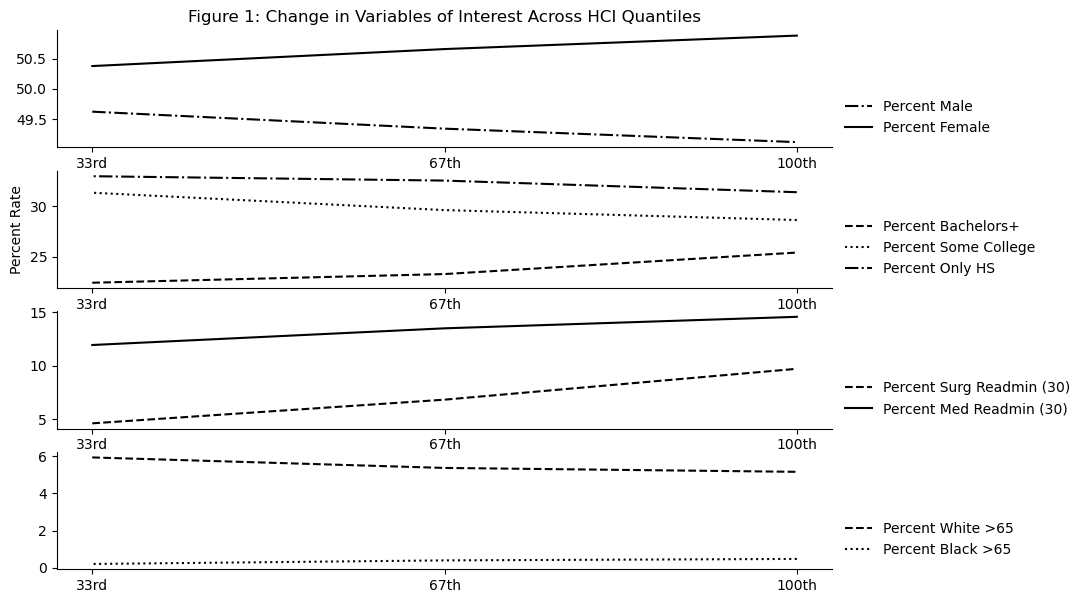

In [77]:
fig, ax = plt.subplots(4,1, figsize = (10,7))

hcitype = 'hci.tercile'

for i in coldict.keys():
    if complete.groupby(hcitype).mean(numeric_only = True).loc[:, coldict.keys()].loc[:, i][0] < 10:
        ax[3].plot(complete.groupby(hcitype).mean(numeric_only = True).loc[:, coldict.keys()].loc[:, i].sort_values(ascending = False), 
                   color = 'black', linestyle = linestyles[i], label = coldict[i])
        
    elif complete.groupby(hcitype).mean(numeric_only = True).loc[:, coldict.keys()].loc[:, i][0] > 45:
        ax[0].plot(complete.groupby(hcitype).mean(numeric_only = True).loc[:, coldict.keys()].loc[:, i].sort_values(ascending = False), 
                   color = 'black', linestyle = linestyles[i], label = coldict[i])
    else:
        ax[1].plot(complete.groupby(hcitype).mean(numeric_only = True).loc[:, coldict.keys()].loc[:, i].sort_values(ascending = True), 
                  color = 'black', linestyle = linestyles[i], label = coldict[i])
        
ax[0].set_title("Figure 1: Change in Variables of Interest Across HCI Quantiles")
ax[1].set_ylabel("Percent Rate")
ax[2].set_xlabel("HCI by Quantile")

    
ax[2].plot(complete.groupby(hcitype).mean(numeric_only = True).loc[:, 'pct.readmin.30.surg'].sort_values(ascending = True), 
                   color = 'black', linestyle = '--', label = 'Percent Surg Readmin (30)')
ax[2].plot(complete.groupby(hcitype).mean(numeric_only = True).loc[:, 'pct.readmin.30.med'].sort_values(ascending = True), 
                   color = 'black', linestyle = '-', label = 'Percent Med Readmin (30)')
    
for a in ax:
    a.legend(frameon = False, loc = 'lower left', bbox_to_anchor = (1, 0))
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

In [78]:
complete['hci.tercile'] = [hci_third[i] for i in complete['hci.tercile']]

In [79]:
complete['hci.quartile'] = [hci_quart[i] for i in complete['hci.quartile']]

In [134]:
# Create a total cost column which is the average costs per person multiplied by people per county/year

complete['total_cost'] = complete['total.a/b.pasr'] * complete['med.enrollee_x']

In [146]:
# Do a summation group to get the total_cost across all counties for each year and HCI

grouped = complete.groupby(['year', 'hci.tercile']).sum()
grouped.reset_index(inplace = True)

C:\Users\jbpul\AppData\Local\Temp\ipykernel_10212\548041067.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = complete.groupby(['year', 'hci.tercile']).sum()


In [163]:
# Average the total cost across years to get the average total cost per year by HCI group

grouped2 = grouped.groupby('hci.tercile')['total_cost', 'med.enrollee_x','total.a/b.pasr'].mean()

C:\Users\jbpul\AppData\Local\Temp\ipykernel_10212\784797436.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped2 = grouped.groupby('hci.tercile')['total_cost', 'med.enrollee_x','total.a/b.pasr'].mean()


In [172]:
(grouped2['med.enrollee_x'] * grouped2['total.a/b.pasr'])/2

hci.tercile
1    5.756086e+12
2    1.058097e+13
3    1.379085e+13
dtype: float64

In [173]:
grouped2['total_cost']

hci.tercile
1    3.051652e+10
2    5.154457e+10
3    7.215908e+10
Name: total_cost, dtype: float64

In [166]:
grouped2['total_cost'].max() - grouped2['total_cost'].min()

41642552636.23139

In [158]:
grouped2.max() - grouped2.min()

total_cost    4.164255e+10
dtype: float64

In [80]:
test1 = complete.groupby('hci.tercile')[['medicare.enrollee', 'total.a/b.pasr']].mean()

In [81]:
test1['mult'] = test1['medicare.enrollee']*test1['total.a/b.pasr']/1000000

In [82]:
test1

,medicare.enrollee,total.a/b.pasr,mult
hci.tercile,,,
1,8857.515096,8514.811748,75.420074
2,12891.641310,9399.730888,121.177959
3,17701.753937,10149.097094,179.656819


In [78]:
complete.to_excel("completedata2.xlsx")

# Iterative Single Value Thresholding

In [169]:
numpydata = completedata.drop(columns = '_merge', axis = 1).fillna(0).to_numpy()

In [147]:
completedata.columns

Index(['hsa.num_x_x_x', 'med.enrollee_x', 'surg.dis.per.1000', 'aaa.per.1000',
       'back.surg.per.1000', 'coron.angio.per.1000', 'coron.art.per.1000',
       'perc.coron.per.1000', 'carot.endar.per.1000', 'cholec.per.1000',
       ...
       'pctnative', '_merge', 'pctlesshs', 'pcthsonly', 'pctsomecol',
       'pctbachplus', 'laborforce', 'employed', 'unemployed', 'ue_rate'],
      dtype='object', length=288)

In [148]:
numpydata[numpydata == 'both'] = 0

In [150]:
numpydata.astype(float).shape

(9235, 288)

In [157]:
lambdas = .1
identity = np.eye(numpydata.shape[0])


In [181]:
np.linalg.matrix_rank(numpydata)

263

In [166]:
U, s, VT = np.linalg.svd(numpydata, full_matrices = False)

In [170]:
def ItSingValThresh(Y, r):
    """
    Iterative Singular Value Thresholding function for Matrix Completion
    """
    tol = 10**(-3)  # difference between iterates at termination
    max_its = 100;
    n,p = Y.shape 
    X = np.array(Y) #make a copy so operations do not mutate the original
    X[np.isnan(X)] = 0 # Fill in missing entries with zeros

    err = 10**6 
    itt = 0
    
    while err > tol and itt < max_its:
        U,s,VT = np.linalg.svd(X, full_matrices=False)
        V, S = VT.T, np.diag(s)
        Xnew = U[:,:r] @ S[:r,:r] @ V.T[:r,:]
        for i in range(n):
            for j in range(p):
                if ~np.isnan(Y[i,j]):  #replace Xnew with known entries
                    Xnew[i,j] = Y[i,j]
        err = np.linalg.norm(X-Xnew,'fro') 
        X = Xnew
        itt += 1
    return X

In [191]:
newnumpy = ItSingValThresh(numpydata, 150)

In [192]:
tester = pd.DataFrame(newnumpy)

In [189]:
completedata - tester

ValueError: cannot join with no overlapping index names

# Everything below here is a testing area

### This next merge is the pivot point: 

### Below this finds finaldata1: This data uses an incomplete set for the Chronic Care data

    1 If we merge right onto "Chronic Care" we reduce down to a size of 2004 HSA's
        2 Note: Chronic Care has our IV variable
    3 If we merge left onto "Post Discharge" we maintain 3087 unique HSA's

In [34]:
merge4 = pd.merge(postdischarge2, chronic_care2, on = ['hsa.num', 'year'], how = 'left')

In [35]:
merge5 = pd.merge(merge1, merge2, on = ['hsa.num', 'year'], how = 'left')

In [36]:
len(set(merge5['hsa.num']))

3437

In [37]:
merge6 = pd.merge(merge3, merge4, on = ['hsa.num', 'year'], how = 'right')

In [38]:
len(set(merge6['hsa.num']))

3087

In [39]:
finaldata_all = pd.merge(merge6, merge5, on = ['hsa.num', 'year'], how = 'left')

### This merge branch merges down to the size of Chronic Care (2004 HSA's) and reduces dataset size signficantly

In [40]:
merge4 = pd.merge(postdischarge2, chronic_care2, on = ['hsa.num', 'year'], how = 'right')

In [41]:
merge5 = pd.merge(merge1, merge2, on = ['hsa.num', 'year'], how = 'left')

In [42]:
len(set(merge5['hsa.num']))

3437

In [43]:
merge6 = pd.merge(merge3, merge4, on = ['hsa.num', 'year'], how = 'right')

In [44]:
len(set(merge6['hsa.num']))

2004

In [45]:
finaldata_cc = pd.merge(merge6, merge5, on = ['hsa.num', 'year'], how = 'left')

In [46]:
len(set(finaldata_cc['hsa.num']))

2004

# Save the main files as excel files

In [50]:
finaldata_cc.to_excel('finaldata_cc.xlsx')

In [51]:
finaldata_all.to_excel('finaldata_all.xlsx')

### Load in the main files, replace na's if necessary

In [221]:
finaldata_cc = pd.read_excel('finaldata_cc.xlsx')

In [ ]:
finaldata_all = pd.read_excel('finaldata_all.xlsx')

In [48]:
# Creates a data dictionary for state to abbreviation

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
    
# invert the dictionary
abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

In [49]:
for i, state in enumerate(finaldata_cc['state_y']):
    finaldata_cc.loc[i, 'state_y'] = abbrev_to_us_state[state].title().strip()


In [50]:
for i, state in enumerate(finaldata_all['state_y']):
    finaldata_all.loc[i, 'state_y'] = abbrev_to_us_state[state].title().strip()

In [51]:
finaldata_cc.loc[:,finaldata_cc.columns.str.contains('state')]

,state_x,state_y,state_x_x,state_y_x,state_x_y,state_y_y
0,AL,Alabama,AL,AL,AL,AL
1,AL,Alabama,AL,AL,AL,AL
2,AL,Alabama,AL,AL,AL,AL
3,AL,Alabama,AL,AL,AL,AL
4,AL,Alabama,AL,AL,AL,AL
...,...,...,...,...,...,...
13802,WY,Wyoming,WY,WY,WY,WY
13803,WY,Wyoming,WY,WY,WY,WY
13804,WY,Wyoming,WY,WY,WY,WY
13805,WY,Wyoming,WY,WY,WY,WY


### Load two versions of the data using the census data

In [52]:
census = pd.read_csv('merged_group.csv')

In [53]:
census = census.set_index(['hsa.num', 'year'])

In [59]:
len(set(finaldata_cc['county']))

1660

In [ ]:
len(set(census['county']))

In [54]:
len(set(finaldata_cc['county']) - set(census['county']))

1603

118

In [261]:
finaldata_all_year = finaldata_all.loc[(finaldata_all['year'] > 2009) & (finaldata_all['year'] < 2016)]
finaldata_all_year.shape

(17195, 213)

In [263]:
finaldata_cc_year = finaldata_cc.loc[(finaldata_cc['year'] > 2009) & (finaldata_cc['year'] < 2016)]
finaldata_cc_year.shape

(10052, 214)

In [278]:
finaldata_all_year.set_index(['hsa.num', 'year'], inplace = True)
finaldata_cc_year.set_index(['hsa.num', 'year'], inplace = True)

In [232]:
census.drop('_merge', inplace = True)

In [299]:
mergeddata = pd.merge(census, finaldata_all_year, left_index = True, right_index = True, how = 'inner').reset_index()

In [300]:
mergeddata.drop('Unnamed: 0', inplace = True, axis = 1)

In [327]:
hsa_keeps = []
for hsa in set(mergeddata['hsa.num']):
    if mergeddata.set_index(['hsa.num', 'year']).xs(hsa, level = 'hsa.num').shape[0] == 6:
        hsa_keeps.append(hsa)

In [342]:
mergeddata = mergeddata.set_index(['hsa.num']).loc[hsa_keeps]

In [346]:
mergeddata.reset_index(inplace = True)

C:\Users\jbpul\AppData\Local\Temp\ipykernel_12828\1628020083.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mergeddata.reset_index(inplace = True)


In [348]:
mergeddata.to_excel('complete_all3.xlsx', index = False)

In [75]:
tester_cc = pd.merge(census, finaldata_cc_year, left_index = True, right_index = True, how = 'inner', indicator = True)

In [204]:
tester_cc.reset_index().to_excel('complete_all.xlsx', index = False)

## Testing zone: Data below here is for testing purposes only

In [57]:
# This looks for how much data is missing 
dropcols = []
for names in finaldata_all.describe().columns:
    if finaldata_all[names].count()/finaldata_all['hsa.num'].count() < .60:
        dropcols.append(names)
    

In [142]:
tester_cc.reset_index(inplace = True)

### This changes year to a list, and then to a date time

tester_cc['year'] = pd.to_datetime([str(year) for year in tester_cc['year'].tolist()])
tester_cc.set_index(['hsa.num', 'year'], inplace = True)

In [163]:
tester_cc.loc[tester_cc['hci.2yr'] > 1, census.columns.tolist()].mean().head(40)

total.population            2.389085e+06
age.male                    4.880489e+01
age.female                  5.119511e+01
med.age                     3.807974e+01
pct.one.race                9.700694e+01
pct.white                   6.681033e+01
pct.black                   1.441402e+01
pct.native.ind              3.594386e-01
pct.asian                   7.954816e+00
pct.island                  1.568421e-01
pct.other.race              7.305596e+00
pct.two+.race               2.993061e+00
pct.hisp.origin             2.385184e+01
pct.white.alone             5.169501e+01
pop.in.house                2.347688e+06
householder.or.spouse       5.372064e+01
parent                      1.794877e+00
other.relatives             3.871101e+01
nonrelatives                5.772298e+00
unmarried.partner           2.118500e+00
num.households1             8.215585e+05
pct.fam.households          6.689236e+01
pct.married.house           4.791525e+01
pct.fem.house               1.389887e+01
pct.nonfam.house

In [155]:
tester_cc.loc[tester_cc['hci.2yr'] < 1, census.columns.tolist()].mean().head(10)

total.population    1.237214e+06
age.male            4.909939e+01
age.female          5.090061e+01
med.age             3.721251e+01
pct.one.race        9.615722e+01
pct.white           7.083124e+01
pct.black           1.012809e+01
pct.native.ind      6.026794e-01
pct.asian           8.492507e+00
pct.island          3.037920e-01
dtype: float64

In [135]:
yearstr

DatetimeIndex(['2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01',
               ...
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01'],
              dtype='datetime64[ns]', length=2650, freq=None)

In [ ]:
tester_cc

In [103]:
tester_cc.loc[tester_cc['_merge'] != 'both'].shape

(0, 420)

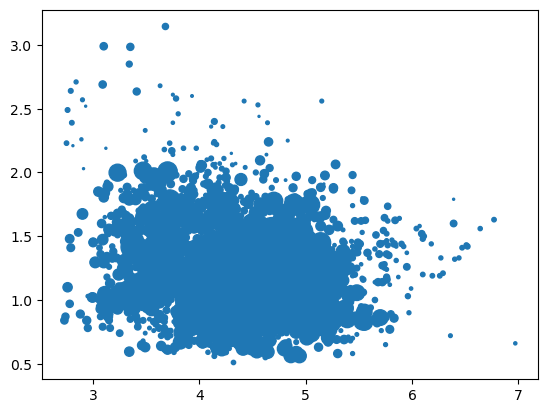

In [105]:
fig, ax = plt.subplots()
#finaldata2 = finaldata2.sample(1000)

ax.scatter(tester_cc['non.hmo.mort.%'], tester_cc['hci.2yr'], s= tester_cc['medicare.enrollee']/500)


plt.show()

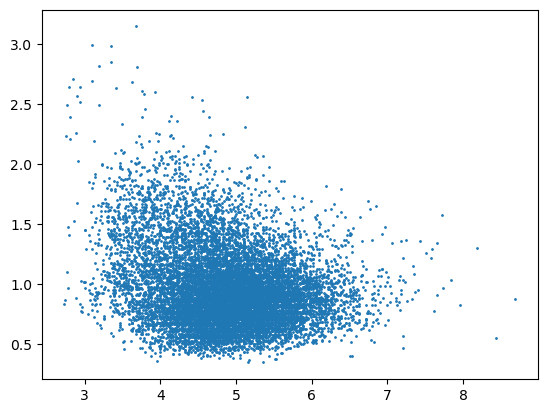

In [199]:
fig, ax = plt.subplots()

ax.scatter(finaldata1['non.hmo.mort.%'], finaldata1['hci.2yr'], s = 1)


plt.show()